<a href="https://colab.research.google.com/github/AnnaPakir/animals_2/blob/main/animals_2_%D0%9F%D1%80%D0%B5%D0%B4%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Начальная настройка весов сверточных нейронных сетей

Цель: Изучить методы начальной насторойки сверточных нейронных весов.

## Часть 1. Библиотеки и функции

In [1]:
# загрузим необходимые библиотеки
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
import os
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import zipfile

In [ ]:
# уберем предупреждения
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Включение mixed precision
set_global_policy('mixed_float16')

In [ ]:
# Функция для построения графиков обучения
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Функция для построения матрицы ошибок
def plot_confusion_matrix(model, val_data, title):
    y_true_classes = []
    y_pred_classes = []
    for batch in val_data:
        x_batch, y_batch = batch[0], batch[1]
        y_pred = model.predict(x_batch, verbose=0)
        y_pred_classes.extend(np.argmax(y_pred, axis=1))
        y_true_classes.extend(np.argmax(y_batch, axis=1))
        if len(y_true_classes) >= val_data.samples:
            break
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

##Загрузка данных

Использовались теже данные, что и при разработке сверточных нейронных сетей https://github.com/AnnaPakir/animals. В работе по ссылке данные уже исследованы. Для уменьшения сильного дисбаланса данных данные обрезаны.

In [ ]:
# раскроем архив
zip_file_path = '/content/animals (1).zip'
extract_to_folder = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_folder)

Для настройки первоначальных весов мы используем все данные, объединив их и исключив target

In [ ]:
# Загрузка данных
file_path = "/content/raw-img"
IMAGES_PER_CLASS = 1446
data = []

# Уменьшение датасета
for class_name in os.listdir(file_path):
    class_folder = os.path.join(file_path, class_name)
    if os.path.isdir(class_folder):
        all_images = os.listdir(class_folder)
        selected_images = random.sample(all_images, min(IMAGES_PER_CLASS, len(all_images)))
        for image_name in selected_images:
            image_path = os.path.join(class_folder, image_name)
            data.append({"filename": image_path, "class": class_name})

df = pd.DataFrame(data)
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

# Генераторы данных
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(320, 250),
    batch_size=32,
    class_mode='categorical'
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(320, 250),
    batch_size=32,
    class_mode='categorical'
)

# Создание генератора для предобучения
def create_unlabeled_generator(train_data, val_data):
    output_signature = (
        tf.TensorSpec(shape=(None, 320, 250, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 320, 250, 3), dtype=tf.float32)
    )
    train_dataset = tf.data.Dataset.from_generator(
        lambda: ((x, x) for x, _ in train_data),
        output_signature=output_signature
    )
    val_dataset = tf.data.Dataset.from_generator(
        lambda: ((x, x) for x, _ in val_data),
        output_signature=output_signature
    )
    unlabeled_dataset = train_dataset.concatenate(val_dataset)
    def fix_batch_shape(inputs, outputs):
        return inputs, outputs
    return unlabeled_dataset.prefetch(tf.data.AUTOTUNE)

unlabeled_data = create_unlabeled_generator(train_data, val_data)

Found 11568 validated image filenames belonging to 10 classes.
Found 2892 validated image filenames belonging to 10 classes.


##Модель

In [ ]:
# Параметры задачи
input_shape = (320, 250, 3)
num_classes = 10

In [ ]:
# Устройство для обучения
device = tf.config.list_physical_devices('GPU')
if device:
    print("Using GPU for training")
else:
    print("Using CPU for training")

Using GPU for training


In [ ]:
# сверточный блок
def conv_block(x, filters, kernel_size, pool_size, dropout_rate=0.5):
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    return x

def model_cnn_4(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = conv_block(inputs, 16, (3, 3), pool_size=(2, 2), dropout_rate=0.3)
    x = conv_block(x, 32, (3, 3), pool_size=(2, 2), dropout_rate=0.4)
    x = conv_block(x, 64, (3, 3), pool_size=(2, 2), dropout_rate=0.4)
    x = GlobalAveragePooling2D()(x)
    x = Dense(16, kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax", dtype='float32')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

##Обучение со случайными первоначальными весами

In [ ]:
model_random = model_cnn_4(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
model_random.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Сброс генераторов
train_data.reset()
val_data.reset()

In [ ]:
# Обучение
%%time
history_random = model_random.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    steps_per_epoch=200,  # ~6400 изображений/эпоху
    validation_steps=50,
    callbacks=[lr_scheduler]
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 655ms/step - accuracy: 0.1291 - loss: 2.6101 - val_accuracy: 0.0913 - val_loss: 2.4227 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 96s 480ms/step - accuracy: 0.1799 - loss: 2.3155 - val_accuracy: 0.1156 - val_loss: 2.3937 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 598ms/step - accuracy: 0.1999 - loss: 2.2249 - val_accuracy: 0.1594 - val_loss: 2.2579 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 714ms/step - accuracy: 0.1973 - loss: 2.2163 - val_accuracy: 0.2219 - val_loss: 2.1831 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 118s 590ms/step - accuracy: 0.2163 - loss: 2.1704 - val_accuracy: 0.1450 - val_loss: 2.3441 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 713ms/step - accuracy: 0.2354 - loss: 2.1515 - val_accuracy: 0.2656 - val_loss: 2.1100 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 703ms/step - accurac

In [ ]:
with open('history_random.pkl', 'wb') as f:
    pickle.dump(history_random.history, f)

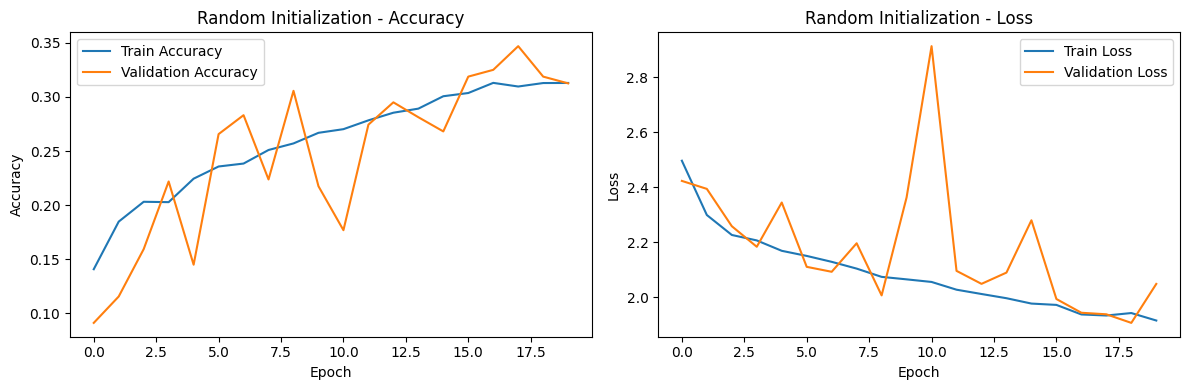

In [ ]:
plot_training_history(history_random, 'Random Initialization')

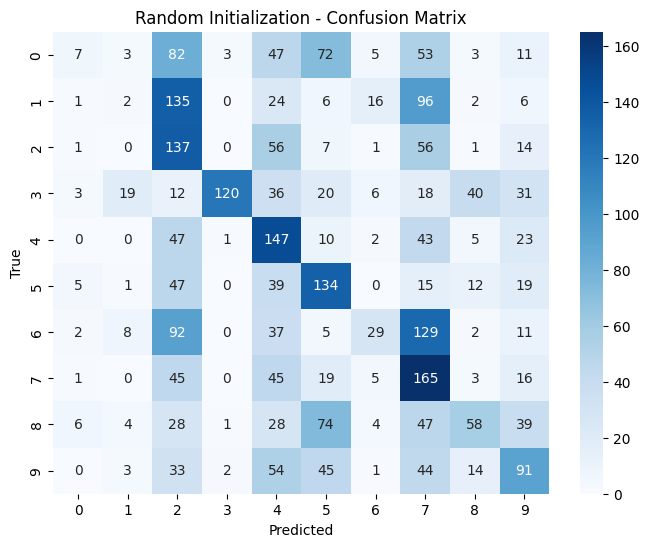

In [ ]:
plot_confusion_matrix(model_random, val_data, 'Random Initialization')

In [ ]:
val_accuracy_random = history_random.history['val_accuracy'][-1]
print(f"Random Initialization Validation Accuracy: {val_accuracy_random:.4f}")

Random Initialization Validation Accuracy: 0.3125


In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
import gc
gc.collect()

0

Обучение модели с случайной инициализацией показывает положительные результаты, однако 20 эпох — это сравнительно короткое время для такой архитектуры, поэтому есть возможность улучшить результаты при более длительном обучении.

##Обучение с автоэнкодером

Автоэнкодер состоит из двух компонентов: энкодера, который преобразует исходное изображение в сжатое (латентное) представление, и декодера, восстанавливающего изображение из этого скрытого пространства.
Основная задача — сделать так, чтобы разница между оригинальным и восстановленным изображением была минимальной, чаще всего это достигается с помощью функции потерь MSE (Mean Squared Error).
В процессе предобучения свёрточные слои энкодера учатся выделять важные признаки — такие как края и текстуры, — что впоследствии может быть полезно для задач классификации.
Такой подход легко интегрируется с архитектурами на основе сверточных нейросетей (CNN).

In [ ]:
# Автоэнкодер
def conv_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    x = conv_block(inputs, 16, (3, 3), pool_size=(2, 2), dropout_rate=0.3)
    x = conv_block(x, 32, (3, 3), pool_size=(2, 2), dropout_rate=0.4)
    encoded = conv_block(x, 64, (3, 3), pool_size=(2, 2), dropout_rate=0.4)
    # Decoder
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0005))(encoded)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (1, 1)))(x)  # (320, 248) -> (320, 250)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', dtype='float32')(x)
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [ ]:
# Предобучение автоэнкодера
autoencoder = conv_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')

# Адаптация unlabeled_data
def fix_batch_shape(inputs, outputs):
    return inputs, outputs

unlabeled_data_fixed = unlabeled_data.map(fix_batch_shape)

autoencoder.fit(
    unlabeled_data_fixed,
    epochs=10,
    steps_per_epoch=100,
    validation_data=unlabeled_data_fixed,
    validation_steps=25,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 788ms/step - loss: 0.1040 - val_loss: 0.0939
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 815ms/step - loss: 0.0283 - val_loss: 0.0807
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 801ms/step - loss: 0.0147 - val_loss: 0.0742
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 943ms/step - loss: 0.0114 - val_loss: 0.0628
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 768ms/step - loss: 0.0105 - val_loss: 0.0402
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 776ms/step - loss: 0.0097 - val_loss: 0.0237
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 748ms/step - loss: 0.0092 - val_loss: 0.0140
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 766ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 757ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 758ms/step - loss: 0.0086 - val_loss: 0.0137


In [ ]:
# Перенос весов
model_autoencoder = model_cnn_4(input_shape, num_classes)
autoencoder_conv_layers = [layer for layer in autoencoder.layers if 'conv2d' in layer.name][:3]
model_conv_layers = [layer for layer in model_autoencoder.layers if 'conv2d' in layer.name][:3]
for auto_layer, model_layer in zip(autoencoder_conv_layers, model_conv_layers):
    if auto_layer.filters == model_layer.filters:
        model_layer.set_weights(auto_layer.get_weights())

In [ ]:
# Обучение
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

model_autoencoder.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Сброс генераторов
train_data.reset()
val_data.reset()

In [ ]:
%%time
history_autoencoder = model_autoencoder.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    steps_per_epoch=200,
    validation_steps=50,
    callbacks=[lr_scheduler]
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 129s 593ms/step - accuracy: 0.1284 - loss: 2.4894 - val_accuracy: 0.0950 - val_loss: 2.3431 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 100s 501ms/step - accuracy: 0.1718 - loss: 2.3025 - val_accuracy: 0.1131 - val_loss: 2.3646 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 120s 601ms/step - accuracy: 0.2049 - loss: 2.2121 - val_accuracy: 0.2244 - val_loss: 2.1407 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 709ms/step - accuracy: 0.2185 - loss: 2.1848 - val_accuracy: 0.2338 - val_loss: 2.1925 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 715ms/step - accuracy: 0.2371 - loss: 2.1351 - val_accuracy: 0.2463 - val_loss: 2.1385 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 479ms/step - accuracy: 0.2555 - loss: 2.1131 - val_accuracy: 0.2481 - val_loss: 2.0870 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 120s 599ms/step - accurac

In [ ]:
with open('history_autoencoder.pkl', 'wb') as f:
    pickle.dump(history_autoencoder.history, f)

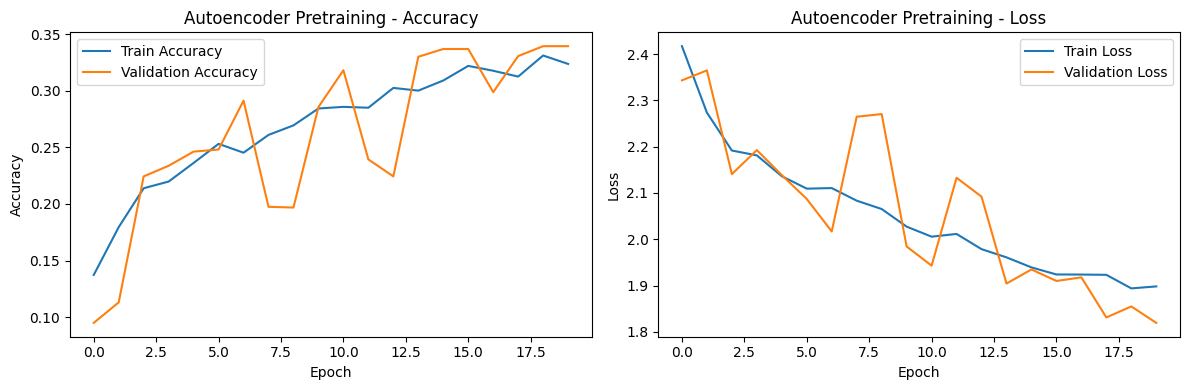

In [ ]:
plot_training_history(history_autoencoder, 'Autoencoder Pretraining')

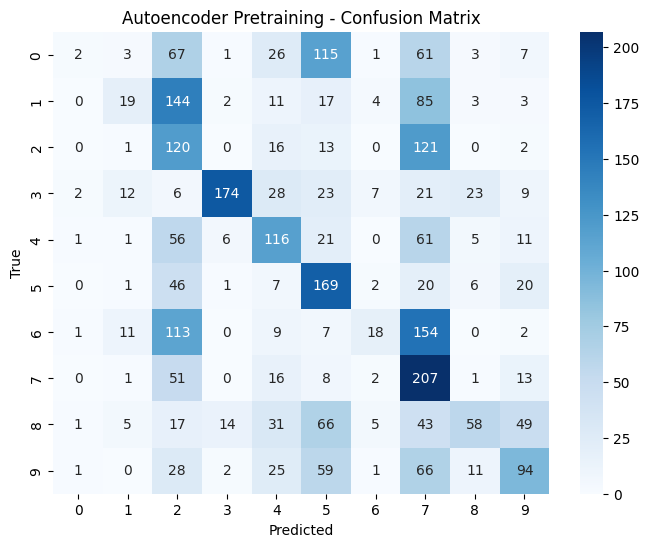

In [ ]:
plot_confusion_matrix(model_autoencoder, val_data, 'Autoencoder Pretraining')

In [ ]:
val_accuracy_autoencoder = history_autoencoder.history['val_accuracy'][-1]
print(f"Autoencoder Pretraining Validation Accuracy: {val_accuracy_autoencoder:.4f}")

Autoencoder Pretraining Validation Accuracy: 0.3394


In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
import gc
gc.collect()

0

<u>Вывод по данной части</u> Автоэнкодер показал результат немного лучше на тех же 20 эпохах, чем пведомное обучение.

## Обучение с SimCLR

SimCLR обучает нейросеть распознавать, какие изображения являются разными вариантами одной и той же исходной картинки (положительные пары), а какие принадлежат к разным объектам (отрицательные пары).
Для этого применяется контрастивная функция потерь NT-Xent, которая поощряет высокое сходство между положительными парами и снижает его между отрицательными.
Такой подход позволяет модели формировать устойчивые (инвариантные) к различным преобразованиям, например, изменениям яркости или поворотам, признаковые представления, которые отлично подходят для задач классификации.
SimCLR отлично работает в сочетании со сверточными нейросетями (CNN).



In [ ]:
# SimCLR
def simclr_model(input_shape):
    base_model = model_cnn_4(input_shape, num_classes)
    x = base_model.layers[-5].output  # До полносвязных слоев
    x = Dense(128, activation=None)(x)
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    return Model(base_model.input, outputs)

In [ ]:
# Контрастивная функция потерь (NT-Xent)
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    batch_size = tf.shape(z1)[0]
    labels = tf.range(batch_size)
    logits = tf.matmul(z1, z2, transpose_b=True) / temperature
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits))
    return loss

In [ ]:
# Аугментации
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
# Предобучение SimCLR
simclr = simclr_model(input_shape)
optimizer_simclr = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step_simclr(images):
    aug1 = data_augmentation(images)
    aug2 = data_augmentation(images)
    with tf.GradientTape() as tape:
        z1 = simclr(aug1)
        z2 = simclr(aug2)
        loss = nt_xent_loss(z1, z2)
    gradients = tape.gradient(loss, simclr.trainable_variables)
    optimizer_simclr.apply_gradients(zip(gradients, simclr.trainable_variables))
    return loss

In [ ]:
# Эмуляция обучения SimCLR
total_steps = 400
for epoch in range(10):
    print(f"SimCLR Epoch {epoch+1}/10")
    total_loss = 0
    for step, batch in enumerate(unlabeled_data.map(lambda x, _: x)):
        loss = train_step_simclr(batch)
        total_loss += loss.numpy()
        if step >= total_steps:
            print(f"Average Loss: {total_loss / (step + 1):.4f}")
            break

SimCLR Epoch 1/10
Average Loss: 2.0957
SimCLR Epoch 2/10
Average Loss: 1.9834
SimCLR Epoch 3/10
Average Loss: 1.9648
SimCLR Epoch 4/10
Average Loss: 1.9355
SimCLR Epoch 5/10
Average Loss: 1.9199
SimCLR Epoch 6/10
Average Loss: 1.9082
SimCLR Epoch 7/10
Average Loss: 1.8906
SimCLR Epoch 8/10
Average Loss: 1.8818
SimCLR Epoch 9/10
Average Loss: 1.8682
SimCLR Epoch 10/10
Average Loss: 1.8613


In [ ]:
# Перенос весов
model_simclr = model_cnn_4(input_shape, num_classes)
simclr_conv_layers = [layer for layer in simclr.layers if 'conv2d' in layer.name][:3]
model_conv_layers = [layer for layer in model_simclr.layers if 'conv2d' in layer.name][:3]
for simclr_layer, model_layer in zip(simclr_conv_layers, model_conv_layers):
    if simclr_layer.filters == model_layer.filters:
        model_layer.set_weights(simclr_layer.get_weights())

In [ ]:
# Обучение
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
model_simclr.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Сброс генераторов
train_data.reset()
val_data.reset()

In [ ]:
%%time
history_simclr = model_simclr.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    steps_per_epoch=200,
    validation_steps=50,
    callbacks=[lr_scheduler]
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 630ms/step - accuracy: 0.1169 - loss: 2.6725 - val_accuracy: 0.1075 - val_loss: 2.4253 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 92s 460ms/step - accuracy: 0.1554 - loss: 2.3727 - val_accuracy: 0.1412 - val_loss: 2.3500 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 116s 578ms/step - accuracy: 0.1728 - loss: 2.3135 - val_accuracy: 0.2119 - val_loss: 2.2199 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 711ms/step - accuracy: 0.2127 - loss: 2.2286 - val_accuracy: 0.2469 - val_loss: 2.1811 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 709ms/step - accuracy: 0.2136 - loss: 2.2112 - val_accuracy: 0.1844 - val_loss: 2.2662 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 713ms/step - accuracy: 0.2415 - loss: 2.1495 - val_accuracy: 0.2138 - val_loss: 2.2607 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 115s 576ms/step - accurac

In [ ]:
with open('history_simclr.pkl', 'wb') as f:
    pickle.dump(history_simclr.history, f)

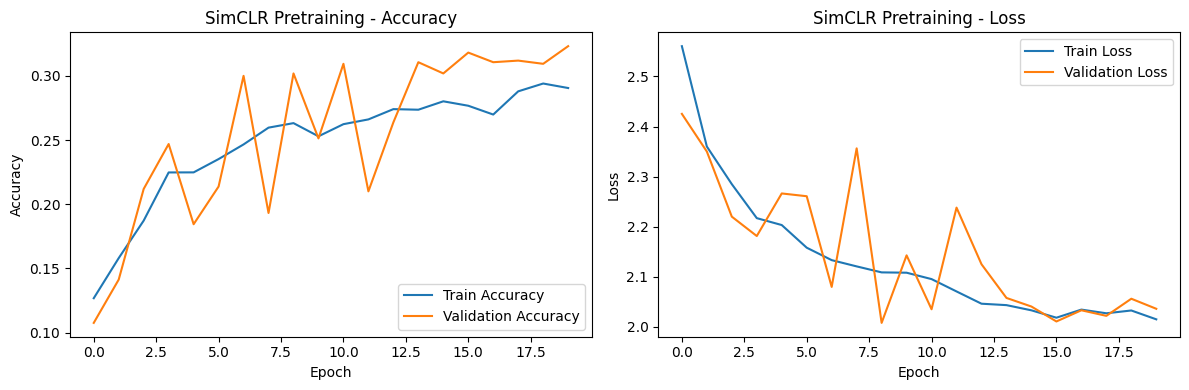

In [ ]:
plot_training_history(history_simclr, 'SimCLR Pretraining')

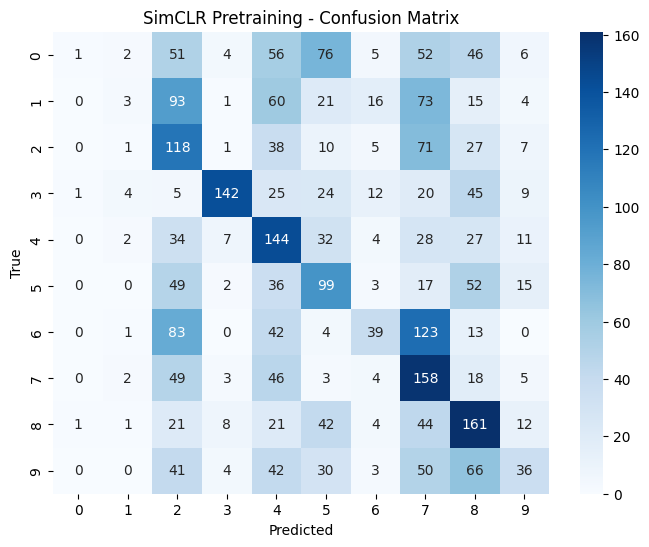

In [ ]:
plot_confusion_matrix(model_simclr, val_data, 'SimCLR Pretraining')

In [ ]:
val_accuracy_simclr = history_simclr.history['val_accuracy'][-1]
print(f"SimCLR Pretraining Validation Accuracy: {val_accuracy_simclr:.4f}")

SimCLR Pretraining Validation Accuracy: 0.3231


In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
import gc
gc.collect()

0

Результаты оказались чуть лучше, чем при случайной инициализации на тех же 20 эпохах, однако немного уступают автоэнкодеру. Скорее всего, для достижения лучших показателей потребуется большее количество эпох обучения.

## Обучение с k-means

Из неразмеченных изображений выбираются небольшие участки (патчи), например, размером 3x3.
Алгоритм k-means затем группирует эти патчи в кластеры, после чего центроиды этих кластеров используются как начальные веса фильтров первого сверточного слоя.

In [ ]:
# Функция для извлечения патчей
def extract_patches_from_generator(data, max_images=3000, patch_size=(5, 5), step=8):
    patches = []
    image_count = 0
    for batch in data:
        for img in batch:
            img = img.numpy()
            for i in range(0, img.shape[0] - patch_size[0] + 1, step):
                for j in range(0, img.shape[1] - patch_size[1] + 1, step):
                    patch = img[i:i+patch_size[0], j:j+patch_size[1], :]
                    patches.append(patch.flatten())
            image_count += 1
            if image_count >= max_images:
                return np.array(patches)
    return np.array(patches)

# Предобучение k-means
patches = extract_patches_from_generator(unlabeled_data.map(lambda x, _: x), max_images=3000, patch_size=(3, 3))
kmeans = KMeans(n_clusters=16, random_state=42).fit(patches)  # 16 кластеров
centroids = kmeans.cluster_centers_.reshape(16, 3, 3, 3)  # (n_clusters, height, width, channels)
centroids = np.transpose(centroids, (1, 2, 3, 0))  # (height, width, channels, n_filters) = (3, 3, 3, 16)

In [ ]:
# Инициализация модели
model_kmeans = model_cnn_4(input_shape, num_classes)
model_kmeans.layers[1].set_weights([centroids, np.zeros(16)])  # Первый Conv2D слой, 32 фильтра

# Обучение
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
model_kmeans.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Сброс генераторов
train_data.reset()
val_data.reset()

In [ ]:
%%time
history_kmeans = model_kmeans.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    steps_per_epoch=200,  # ~6400 изображений/эпоху
    validation_steps=50,  # ~1600 изображений
    callbacks=[lr_scheduler]
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 147s 674ms/step - accuracy: 0.0971 - loss: 2.6758 - val_accuracy: 0.1144 - val_loss: 2.4120 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 101s 506ms/step - accuracy: 0.1086 - loss: 2.4533 - val_accuracy: 0.0869 - val_loss: 2.3968 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 705ms/step - accuracy: 0.1259 - loss: 2.3984 - val_accuracy: 0.1575 - val_loss: 2.3450 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 715ms/step - accuracy: 0.1588 - loss: 2.3360 - val_accuracy: 0.1575 - val_loss: 2.3714 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 202s 819ms/step - accuracy: 0.1682 - loss: 2.2940 - val_accuracy: 0.1531 - val_loss: 2.3059 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 713ms/step - accuracy: 0.2001 - loss: 2.2493 - val_accuracy: 0.1781 - val_loss: 2.2998 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 625ms/step - accura

In [ ]:
with open('history_kmeans.pkl', 'wb') as f:
    pickle.dump(history_kmeans.history, f)

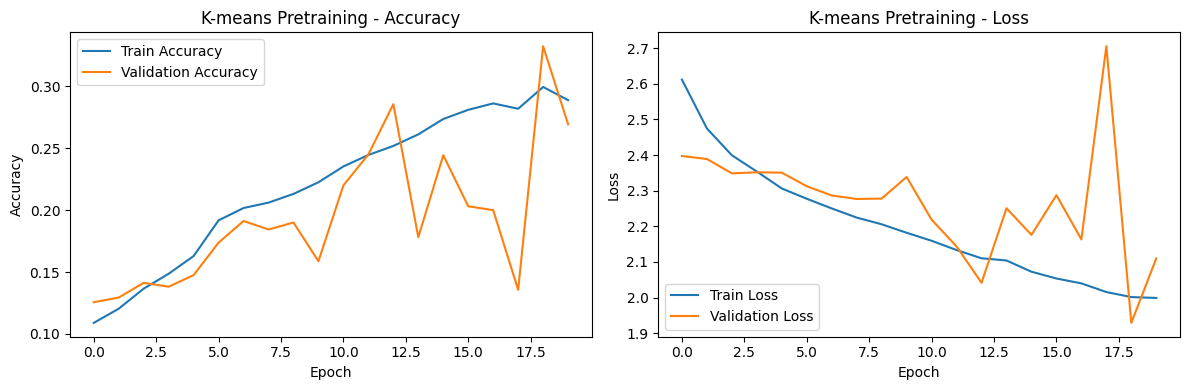

In [ ]:
plot_training_history(history_kmeans, 'K-means Pretraining')

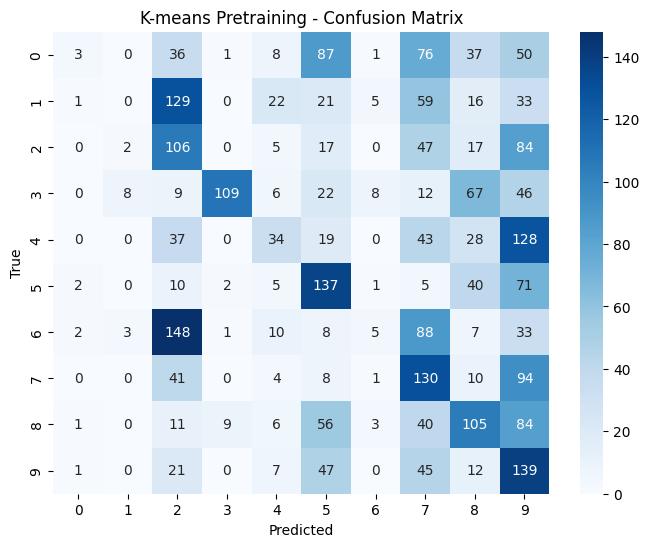

In [ ]:
plot_confusion_matrix(model_kmeans, val_data, 'K-means Pretraining')

In [ ]:
val_accuracy_kmeans = history_kmeans.history['val_accuracy'][-1]
print(f"K-means Pretraining Validation Accuracy: {val_accuracy_kmeans:.4f}")

K-means Pretraining Validation Accuracy: 0.2694


In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
import gc
gc.collect()

0

В этом случае результат оказался наихудшим. Возможно, такой подход не подходит для данной конкретной выборки данных.

##Результаты и выводы


Comparison of Validation Accuracies:
----------------------------------------
Random Initialization: 0.3125
Autoencoder Pretraining: 0.3394
SimCLR Pretraining: 0.3231
K-means Pretraining: 0.2694


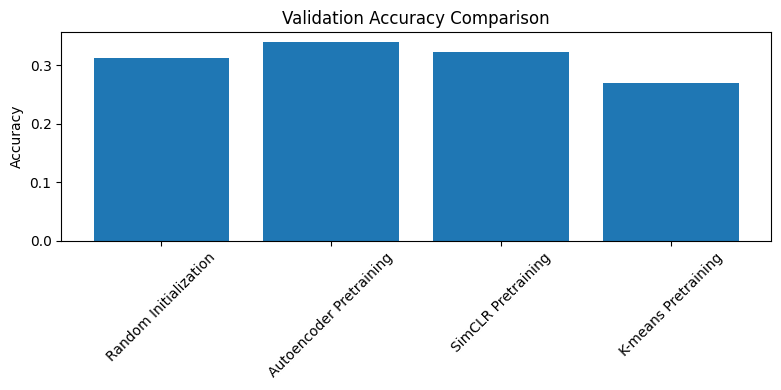

In [ ]:
results = {
    'Random Initialization': 0.3125,
    'Autoencoder Pretraining': 0.3394,
    'SimCLR Pretraining': 0.3231,
    'K-means Pretraining': 0.2694
}

print("\nComparison of Validation Accuracies:")
print("-" * 40)
for method, accuracy in results.items():
    print(f"{method}: {accuracy:.4f}")

plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values())
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()